In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!pip install tensorflow matplotlib

Another implementation of EfficientNet

In [3]:
# I want to start importing the base packages that we need to train our CNN
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.metrics import f1_score
import numpy as np
from collections import defaultdict
import torch.nn.functional as F
from PIL import Image
import os
from torchvision.models import EfficientNet_B0_Weights
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pickle
import logging
from torchvision.models import EfficientNet_B6_Weights

In [4]:
class PreprocessedDataset(torch.utils.data.Dataset):
    def __init__(self, folder):
        self.file_paths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(folder) for f in filenames]
        self.classes = sorted(set(os.path.basename(os.path.dirname(fp)) for fp in self.file_paths))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        image = torch.load(self.file_paths[idx])
        label = self.get_label_from_path(self.file_paths[idx])
        return image, label

    def get_label_from_path(self, path):
        class_name = os.path.basename(os.path.dirname(path))
        return self.class_to_idx[class_name]

# Create datasets and dataloaders
base_train_dataset = PreprocessedDataset("/content/drive/MyDrive/YBIGTA 신입플/TransformedDatasets/base_NB_train")
blur_train_dataset = PreprocessedDataset("/content/drive/MyDrive/YBIGTA 신입플/TransformedDatasets/blur_NB_train")
val_dataset = PreprocessedDataset("/content/drive/MyDrive/YBIGTA 신입플/TransformedDatasets/NB_val")
test_dataset = PreprocessedDataset("/content/drive/MyDrive/YBIGTA 신입플/TransformedDatasets/NB_test")

In [9]:
base_train_loader = DataLoader(base_train_dataset, batch_size=32, shuffle=True, num_workers=1)
blur_train_loader = DataLoader(blur_train_dataset, batch_size=32, shuffle=True, num_workers=1)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=1)

In [10]:
efficientnet = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

# Creating the final output vector
num_classes = 12
efficientnet.classifier = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(efficientnet.classifier[1].in_features, num_classes)
)

# Moving slides if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efficientnet = efficientnet.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Early stopping if we see a plateau in training improvement
best_loss = float('inf')
epochs_no_improve = 0
patience = 5

# Calculating top-k accuracy
def calculate_top_k_accuracy(outputs, labels, k=1):
    with torch.no_grad():
        max_k_preds = torch.topk(outputs, k, dim=1)[1]
        correct_k = max_k_preds.eq(labels.view(-1, 1).expand_as(max_k_preds))  # Compare to true labels
        correct_k = correct_k.float().sum().item()
    return correct_k

# Validation function
def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct_top1 = 0
    correct_top2 = 0
    correct_top3 = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            print("i", end="")

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            correct_top1 += calculate_top_k_accuracy(outputs, labels, k=1)
            correct_top2 += calculate_top_k_accuracy(outputs, labels, k=2)
            correct_top3 += calculate_top_k_accuracy(outputs, labels, k=3)
            total += labels.size(0)

    val_loss /= len(val_loader)
    top1_acc = 100. * correct_top1 / total
    top2_acc = 100. * correct_top2 / total
    top3_acc = 100. * correct_top3 / total
    print("\n")
    print(f"Validation Loss: {val_loss:.4f}, Top-1 Acc: {top1_acc:.2f}%, Top-2 Acc: {top2_acc:.2f}%, Top-3 Acc: {top3_acc:.2f}%")

    return val_loss, top1_acc, top2_acc, top3_acc

# Training Function
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10, patience=5):
    global best_loss, epochs_no_improve
    for epoch in range(num_epochs):
        model.train()

        running_loss = 0.0
        correct_top1 = 0
        correct_top2 = 0
        correct_top3 = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            print("i", end="")

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct_top1 += calculate_top_k_accuracy(outputs, labels, k=1)
            correct_top2 += calculate_top_k_accuracy(outputs, labels, k=2)
            correct_top3 += calculate_top_k_accuracy(outputs, labels, k=3)
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        top1_acc = 100. * correct_top1 / total
        top2_acc = 100. * correct_top2 / total
        top3_acc = 100. * correct_top3 / total
        print(f"\nEpoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Top-1 Acc: {top1_acc:.2f}%, Top-2 Acc: {top2_acc:.2f}%, Top-3 Acc: {top3_acc:.2f}%")

        val_loss, _, _, _ = validate(model, val_loader, criterion)

        # Adjust learning rate based on validation loss
        scheduler.step(val_loss)

        # Looking at current learning rate
        current_lr = scheduler.optimizer.param_groups[0]['lr']
        print(f"Learning rate: {current_lr}")

        # Checking if we need to stop the further training of our model
        if val_loss < best_loss:
            best_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"Validation loss improved. Model saved at epoch {epoch + 1}")
        else:
            epochs_no_improve += 1
            print(f"No improvement in validation loss for {epochs_no_improve} epochs")

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break

    print("Training complete.")

train(efficientnet, blur_train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, patience=5)

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 

In [ ]:
# Saving it within my Google Drive
model_save_path = "/content/drive/MyDrive/YBIGTA 신입플/Models/blur_best_efficientnetb0.pth"
torch.save(efficientnet.state_dict(), model_save_path)

In [ ]:
def test_model(model, test_loader):
    model.eval()
    correct_top1 = 0
    correct_top2 = 0
    correct_top3 = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            correct_top1 += calculate_top_k_accuracy(outputs, labels, k=1)
            correct_top2 += calculate_top_k_accuracy(outputs, labels, k=2)
            correct_top3 += calculate_top_k_accuracy(outputs, labels, k=3)
            total += labels.size(0)

    top1_acc = 100. * correct_top1 / total
    top2_acc = 100. * correct_top2 / total
    top3_acc = 100. * correct_top3 / total

    print(f"Test Results - Top-1 Acc: {top1_acc:.2f}%, Top-2 Acc: {top2_acc:.2f}%, Top-3 Acc: {top3_acc:.2f}%")

test_model(efficientnet, test_loader)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78bf14dee0e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78bf14dee0e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Test Results - Top-1 Acc: 44.44%, Top-2 Acc: 62.50%, Top-3 Acc: 73.72%


In the implementation below, I did this after I trained my model above. I loaded the previous trained weights into the efficientnet model to see the average feature representations that our model learned to represent each class. We decided to use the testing dataset because we thought that it would suffice to see the average feature representation of each class for 100 images.

In [ ]:
from collections import defaultdict

In [ ]:
efficientnet = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

num_classes = 12
efficientnet.classifier = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(efficientnet.classifier[1].in_features, num_classes)
)

model_save_path = "/content/drive/MyDrive/YBIGTA 신입플/Models/blur_best_efficientnetb0.pth"
efficientnet.load_state_dict(torch.load(model_save_path))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efficientnet = efficientnet.to(device)

# Setting the model to evaluation mode to prepare it for feature extraction
efficientnet.eval()

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 115MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
# Using the test dataset to see the average feature representation of each class
testing_dataset = DataLoader(test_dataset, batch_size=1, num_workers=0)

In [ ]:
# This block of code is to get the average feature representations in a dictionary
class EfficientNetFeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super(EfficientNetFeatureExtractor, self).__init__()
        # Removing the final classification layer
        self.features = nn.Sequential(
            original_model.features,
            original_model.avgpool
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return x

feature_extractor = EfficientNetFeatureExtractor(efficientnet).to(device)
feature_extractor.eval()

# Store features of each class
class_feature_vectors = defaultdict(list)

with torch.no_grad():
    for inputs, labels in testing_dataset:
        inputs = inputs.to(device)
        labels = labels.to(device)

        features = feature_extractor(inputs)

        for feature, label in zip(features, labels):
            class_feature_vectors[label.item()].append(feature.cpu().numpy())

# From the dictionary that we made above, calculate the average feature representation
average_class_features = {}
for class_idx, features in class_feature_vectors.items():
    features = np.array(features)

    average_class_features[class_idx] = np.mean(features, axis=0)

# Testing if each class has a vector within it
for class_idx, avg_features in average_class_features.items():
    print(f"Class {class_idx}: Average Feature Representation: {avg_features}")

Class 11: Average Feature Representation: [1.2805333e-04 1.1432333e-01 2.7530628e-01 ... 1.1855633e-01 6.2254246e-02
 1.2162155e-01]
Class 0: Average Feature Representation: [ 0.05164265  0.14615913 -0.03896993 ...  0.20456287  0.23681203
  0.07492048]
Class 5: Average Feature Representation: [ 0.10801828  0.10593321 -0.02053016 ...  0.29562268  0.16737679
  0.133389  ]
Class 10: Average Feature Representation: [ 0.2588672  -0.02191424  0.46287322 ...  0.18165539 -0.04235479
  0.07244021]
Class 4: Average Feature Representation: [ 0.02400762  0.45863968 -0.09642829 ...  0.24143255  0.55312276
  0.10429553]
Class 8: Average Feature Representation: [0.07327624 0.29695523 0.00425094 ... 0.2151273  0.14552967 0.13316965]
Class 1: Average Feature Representation: [ 0.0105146   0.18646505 -0.01310651 ...  0.16305248  0.4348898
  0.12050226]
Class 7: Average Feature Representation: [ 0.04170129  0.28293043 -0.05536924 ...  0.25021064  0.44654277
  0.0741244 ]
Class 6: Average Feature Represent

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 4352 (\N{HANGUL CHOSEONG KIYEOK}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 4457 (\N{HANGUL JUNGSEONG O}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 4369 (\N{HANGUL CHOSEONG PHIEUPH}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 4467 (\N{HANGUL JUNGSEONG EU}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 4367 (\N{HANGUL CHOSEONG KHIEUKH}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 4363 (\N{HANGUL CHOSEONG IEUNG}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/

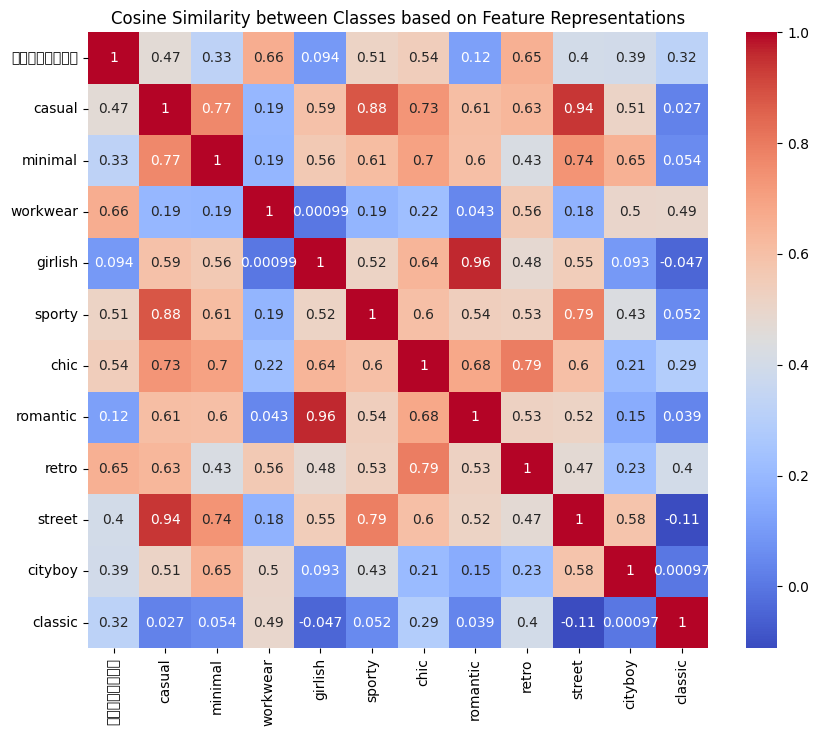

In [ ]:
# This block of code is to create a correlation matrix of all the feature representations learned
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

# Trying to match the class names with the associated fashion style
idx_to_class = {v: k for k, v in base_train_dataset.class_to_idx.items()}

class_feature_vectors = defaultdict(list)

# Extract features from the testing_dataset using your feature extractor
with torch.no_grad():
    for inputs, labels in testing_dataset:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Extract features
        features = feature_extractor(inputs)

        # Store feature vectors by class names instead of indices
        for feature, label in zip(features, labels):
            class_name = idx_to_class[label.item()]
            class_feature_vectors[class_name].append(feature.cpu().numpy())

# Calculate the average feature representation for each class
average_class_features = {}
for class_name, features in class_feature_vectors.items():
    features = np.array(features)
    average_class_features[class_name] = np.mean(features, axis=0)

class_names = list(average_class_features.keys())

# Calculate cosine similarities between class feature vectors
n_classes = len(class_names)
cosine_sim_matrix = np.zeros((n_classes, n_classes))

for i, class_name_1 in enumerate(class_names):
    for j, class_name_2 in enumerate(class_names):
        if i != j:
            cos_sim = 1 - cosine(average_class_features[class_name_1], average_class_features[class_name_2])
            cosine_sim_matrix[i, j] = cos_sim
        else:
            cosine_sim_matrix[i, j] = 1.0  # Similarity with itself

# Plot the cosine similarity matrix as a heatmap using the coolwarm colorscheme
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim_matrix, xticklabels=class_names, yticklabels=class_names, annot=True, cmap='coolwarm')
plt.title("Cosine Similarity between Classes based on Feature Representations")
plt.show()

In [ ]:
# Saving the average feature representations in my google drop
file_path = '/content/drive/MyDrive/YBIGTA 신입플/Models/average_class_features.pt'

# Save the average_class_features dictionary to the file
torch.save(average_class_features, file_path)

print(f"average_class_features saved to {file_path}")

average_class_features saved to /content/drive/MyDrive/YBIGTA 신입플/Models/average_class_features.pt
